# Tugas Individu - Rekayasa Fitur
10122099<br>
Muhammad Raffy Abdillah<br>
IF-3<br>
Rekayasa Fitur Data Video<br>


Tahap 1: Import Pustaka dan Video

In [34]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
video = 'Kereta.mp4'

Tahap 2: Menampilkan Video

In [3]:
file_vid = cv2.VideoCapture(video)

while True:
    berhasil, bingkai = file_vid.read()
    if not berhasil:
        break
    cv2.imshow('Video Asli', bingkai)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

file_vid.release()
cv2.destroyAllWindows()

Tahap 3: Praproses (Resize & Grayscale)

In [4]:
file_vid = cv2.VideoCapture(video)

fps = file_vid.get(cv2.CAP_PROP_FPS)
print(f"FPS Video: {fps}")
berhasil, bingkai = file_vid.read()
tinggi, lebar = bingkai.shape[:2]

skala = 50
lebar_vid = int(lebar * skala / 100)
tinggi_vid = int(tinggi * skala / 100)

delay = int (500 / fps)

while True:
    berhasil, bingkai = file_vid.read()
    if not berhasil:
        file_vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
        continue
    ukuran = cv2.resize(bingkai, (lebar_vid, tinggi_vid))

    vid_abu = cv2.cvtColor(ukuran, cv2.COLOR_BGR2GRAY)

    cv2.imshow('Video Berubah Ukuran & Grayscale', vid_abu)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

file_vid.release()
cv2.destroyAllWindows()

FPS Video: 30.181098386723857


Tahap 4a: Ekstraksi Fitur (Frame Differencing)

In [5]:
file_vid = cv2.VideoCapture(video)

berhasil, bingkai = file_vid.read()
tinggi, lebar = bingkai.shape[:2]

skala = 50
lebar_vid = int(lebar * skala / 100)
tinggi_vid = int(tinggi * skala / 100)

prev_gray = None
frame_diff = []

while True:
    berhasil, bingkai = file_vid.read()
    if not berhasil:
        break

    ukuran = cv2.resize(bingkai, (lebar_vid, tinggi_vid))
    vid_abu = cv2.cvtColor(ukuran, cv2.COLOR_BGR2GRAY)

    if prev_gray is not None:
        diff = cv2.absdiff(vid_abu, prev_gray)
        _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

        score = np.sum(thresh) / 255
        frame_diff .append(score)

        cv2.imshow('Frame Differencing', thresh)

    prev_gray = vid_abu.copy()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

file_vid.release()
cv2.destroyAllWindows()

df = pd.DataFrame({'Jumlah Tepi Piksel': frame_diff})
df.to_csv('fitur_fd.csv', index=False)

Tahap 4b: Ekstraksi Fitur (Motion History Image)

In [6]:
def grid_pooling(mhi_img, grid=(4,4)):
    h, w = mhi_img.shape
    gh, gw = grid
    result = []
    for y in range(gh):
        for x in range(gw):
            y1 = y * h // gh
            y2 = (y + 1) * h // gh
            x1 = x * w // gw
            x2 = (x + 1) * w // gw
            block = mhi_img[y1:y2, x1:x2]
            result.append(np.mean(block))
    return np.array(result)

In [21]:
file_vid = cv2.VideoCapture(video)

berhasil, bingkai = file_vid.read()
tinggi, lebar = bingkai.shape[:2]

skala = 50
lebar_vid = int(lebar * skala / 100)
tinggi_vid = int(tinggi * skala / 100)

prev_gray = None
mhi = np.zeros((tinggi_vid, lebar_vid), dtype=np.float32)
durasi = 100
timestamp = 0

fitur_mhi = []

while True:
    berhasil, bingkai = file_vid.read()
    if not berhasil:
        break 

    ukuran = cv2.resize(bingkai, (lebar_vid, tinggi_vid))
    vid_abu = cv2.cvtColor(ukuran, cv2.COLOR_BGR2GRAY)

    if prev_gray is not None:
        diff = cv2.absdiff(vid_abu, prev_gray)
        _, motion_mask = cv2.threshold(diff, 25, 1, cv2.THRESH_BINARY)

        timestamp += 1
        mhi[motion_mask == 1] = timestamp
        mhi[motion_mask == 0] -= 1
        mhi[mhi < (timestamp-durasi)] = 0

        mhi_disp = np.uint8(np.clip((mhi - (timestamp- durasi)) / durasi * 255, 0, 255))

        mhi_vector = grid_pooling(mhi_disp, grid=(4, 4))
        fitur_mhi.append(mhi_vector)

        cv2.imshow('MHI', mhi_disp)

    prev_gray = vid_abu.copy()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

file_vid.release()
cv2. destroyAllWindows()

fitur_mhi = np.array(fitur_mhi)
df_fitur = pd.DataFrame(fitur_mhi)
df_fitur.to_csv("fitur_mhi.csv", index=False)

In [66]:
file_vid = cv2.VideoCapture(video)

berhasil, bingkai = file_vid.read()
tinggi, lebar = bingkai.shape[:2]

skala = 50
lebar_vid = int(lebar * skala / 100)
tinggi_vid = int(tinggi * skala / 100)

prev_gray = None
mhi = np.zeros((tinggi_vid, lebar_vid), dtype=np.float32)
durasi = 100
timestamp = 0

file_vid.set(cv2.CAP_PROP_POS_FRAMES, 0)

while True:
    berhasil, bingkai = file_vid.read()
    if not berhasil:
        break

    ukuran = cv2.resize(bingkai, (lebar_vid, tinggi_vid))
    vid_abu = cv2.cvtColor(ukuran, cv2.COLOR_BGR2GRAY)

    if prev_gray is not None:
        # Frame Differencing
        diff = cv2.absdiff(vid_abu, prev_gray)
        _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
        diff_bgr = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

        # MHI
        _, motion_mask = cv2.threshold(diff, 25, 1, cv2.THRESH_BINARY)
        timestamp += 1
        mhi[motion_mask == 1] = timestamp
        mhi[motion_mask == 0] -= 1
        mhi[mhi < (timestamp - durasi)] = 0
        mhi_disp = np.uint8(np.clip((mhi - (timestamp - durasi)) / durasi * 255, 0, 255))
        mhi_bgr = cv2.cvtColor(mhi_disp, cv2.COLOR_GRAY2BGR)

        gabung = np.hstack((diff_bgr, mhi_bgr))
        cv2.imshow('Gabungan Frame Diff + MHI', gabung)

    prev_gray = vid_abu.copy()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

file_vid.release()
cv2.destroyAllWindows()

Tahap 5: Hasil Visual

Penjelasan Nilai Vektor

In [30]:
df_fd = pd.read_csv('fitur_fd.csv')
df_mhi = pd.read_csv('fitur_mhi.csv')

print('Penjelasan Frame Differencing')
df_fd.describe()

Penjelasan Frame Differencing


,Jumlah Tepi Piksel
count,423.000000
mean,3208.295508
std,1366.248486
min,0.000000
25%,2010.500000
50%,3222.000000
75%,4247.000000
max,7509.000000


In [31]:
print('Penjelasan Motion History Image')
df_mhi.describe()

Penjelasan Motion History Image


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000
mean,19.650118,19.650118,19.650118,19.652656,21.137936,19.897329,20.635836,19.825851,78.727822,77.011305,19.948418,20.193903,156.272358,72.662339,26.497766,19.976177
std,49.506384,49.506384,49.506384,49.505374,49.555344,49.564707,49.525677,49.524448,36.199127,33.938001,49.465306,49.426557,64.019715,51.305137,50.104408,49.573933
min,0.000000,0.000000,0.000000,0.000000,0.515139,0.000000,0.082153,0.000000,40.881250,38.605903,0.102847,0.104514,40.139097,12.014931,0.071528,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.742778,0.045104,0.394271,0.034653,57.279618,61.002813,0.197431,0.214549,98.765000,25.441806,0.926632,0.018472
50%,0.000000,0.000000,0.000000,0.000000,0.897708,0.141667,0.722153,0.083750,67.665069,71.117083,0.305972,0.710417,174.292431,73.896875,2.757431,0.079514
75%,0.000000,0.000000,0.000000,0.030417,2.729757,0.325174,2.026285,0.471215,89.418299,79.289826,0.490069,1.039826,216.315451,94.915347,29.758646,1.030069
max,249.000000,249.000000,249.000000,249.000000,249.032083,249.002917,249.057500,249.028333,249.046667,249.009167,249.070833,249.041667,249.540833,249.164167,249.488333,249.106667


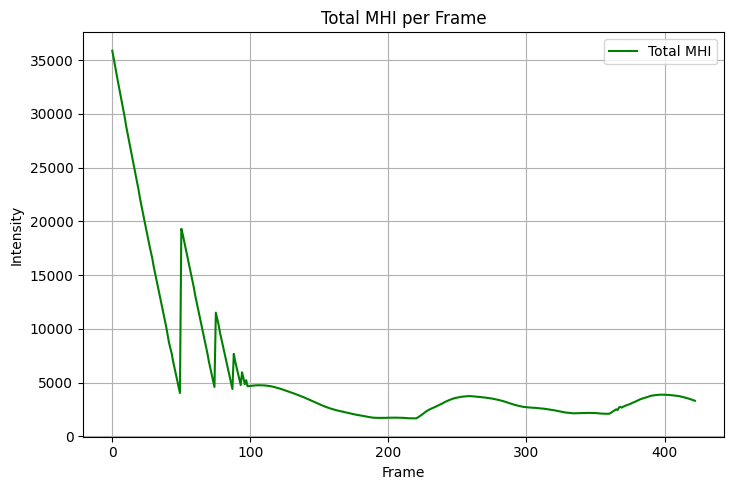

In [64]:
plt.figure(figsize=(14, 5))

df_mhi['total_mhi'] = df_mhi.sum(axis=1)

plt.subplot(1, 2, 1)
plt.plot(df_mhi['total_mhi'], label='Total MHI', color='green')
plt.title('Total MHI per Frame')
plt.xlabel('Frame')
plt.ylabel('Intensity')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

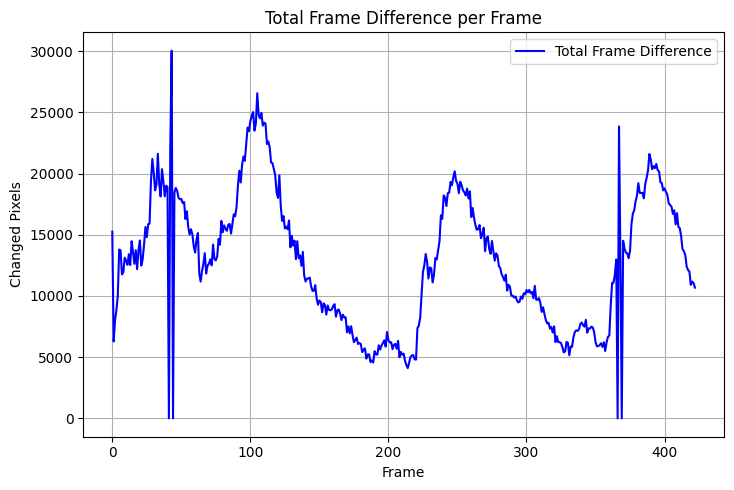

In [58]:
plt.figure(figsize=(14, 5))

df_fd['total_fd'] = df_fd.sum(axis=1)

plt.subplot(1, 2, 2)
plt.plot(df_fd['total_fd'], label='Total Frame Difference', color='blue')
plt.title('Total Frame Difference per Frame')
plt.xlabel('Frame')
plt.ylabel('Changed Pixels')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Plot Perbandingan Gerakan Frame Differencing dengan MHI

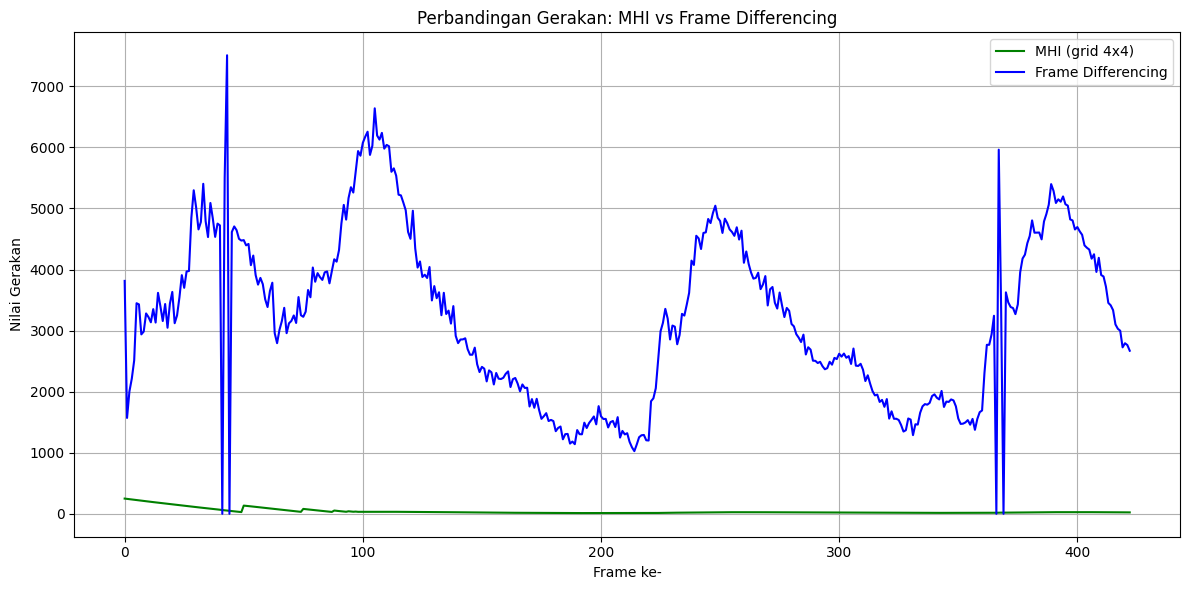

In [ ]:
mhi_mean_per_frame = df_mhi.mean(axis=1)
diff_values = df_fd.iloc[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(mhi_mean_per_frame, label='MHI (grid 4x4)', color='green')

if len(mhi_mean_per_frame) == len(diff_values):
    plt.plot(diff_values, label='Frame Differencing', color='blue')

plt.title("Perbandingan Gerakan: MHI vs Frame Differencing")
plt.xlabel("Frame ke-")
plt.ylabel("Nilai Gerakan")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


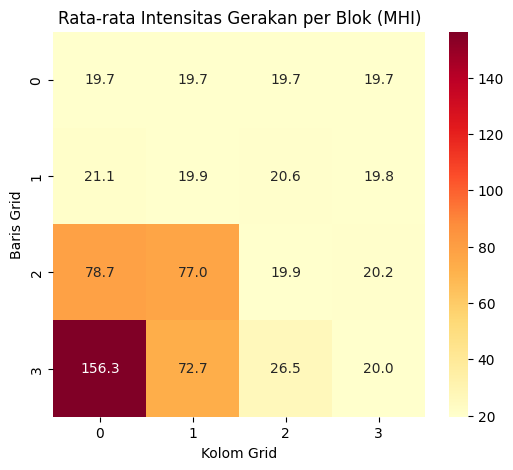

In [48]:
mean_mhi = df_mhi.mean()

grid_size = (4, 4)
mhi_grid = mean_mhi.values.reshape(grid_size)

plt.figure(figsize=(6, 5))
sns.heatmap(mhi_grid, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Rata-rata Intensitas Gerakan per Blok (MHI)")
plt.xlabel("Kolom Grid")
plt.ylabel("Baris Grid")
plt.show()

Plot Perbandingan Intensitas Gerakan MHI setiap Grid

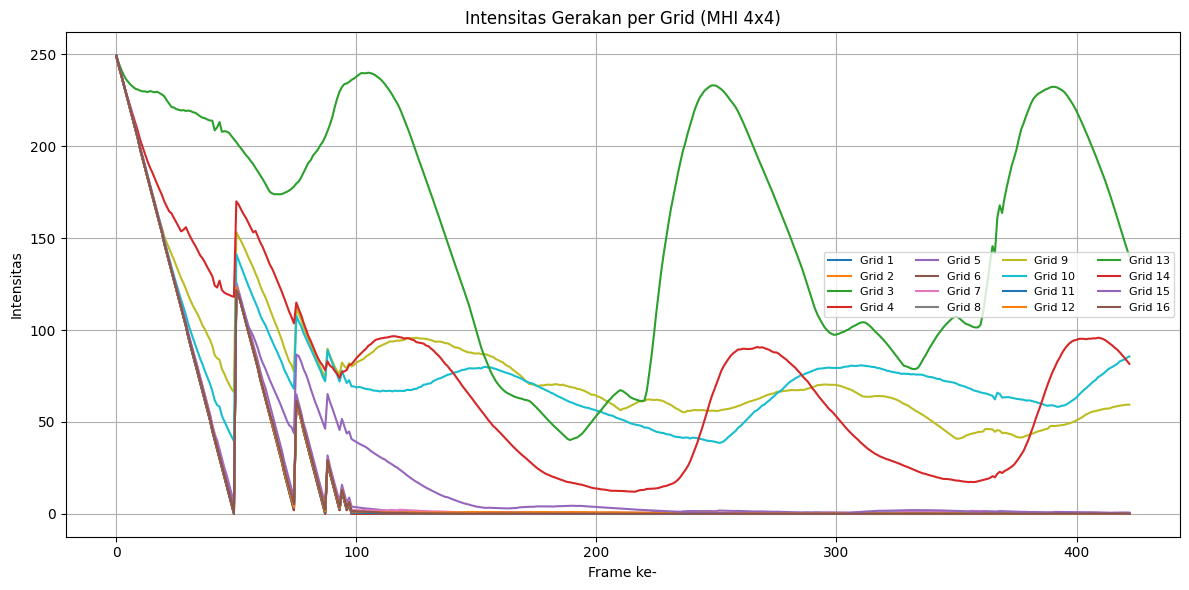

In [49]:
plt.figure(figsize=(12, 6))
for i in range(df_mhi.shape[1]):
    plt.plot(df_mhi.iloc[:, i], label=f'Grid {i+1}')
plt.title("Intensitas Gerakan per Grid (MHI 4x4)")
plt.xlabel("Frame ke-")
plt.ylabel("Intensitas")
plt.legend(ncol=4, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()